# Simple Implementation of Mixture of Experts

### ⚠ I edit on this originial code and convert it to Tensorflow
Pytorch Code : https://colab.research.google.com/drive/1W4Ye_Gog1liK0LThjqYjFSlQaLfHwBZ0?usp=sharing#scrollTo=3c643949-3445-42df-ad02-ff4f945fb601

## Mixture of Experts Architecture
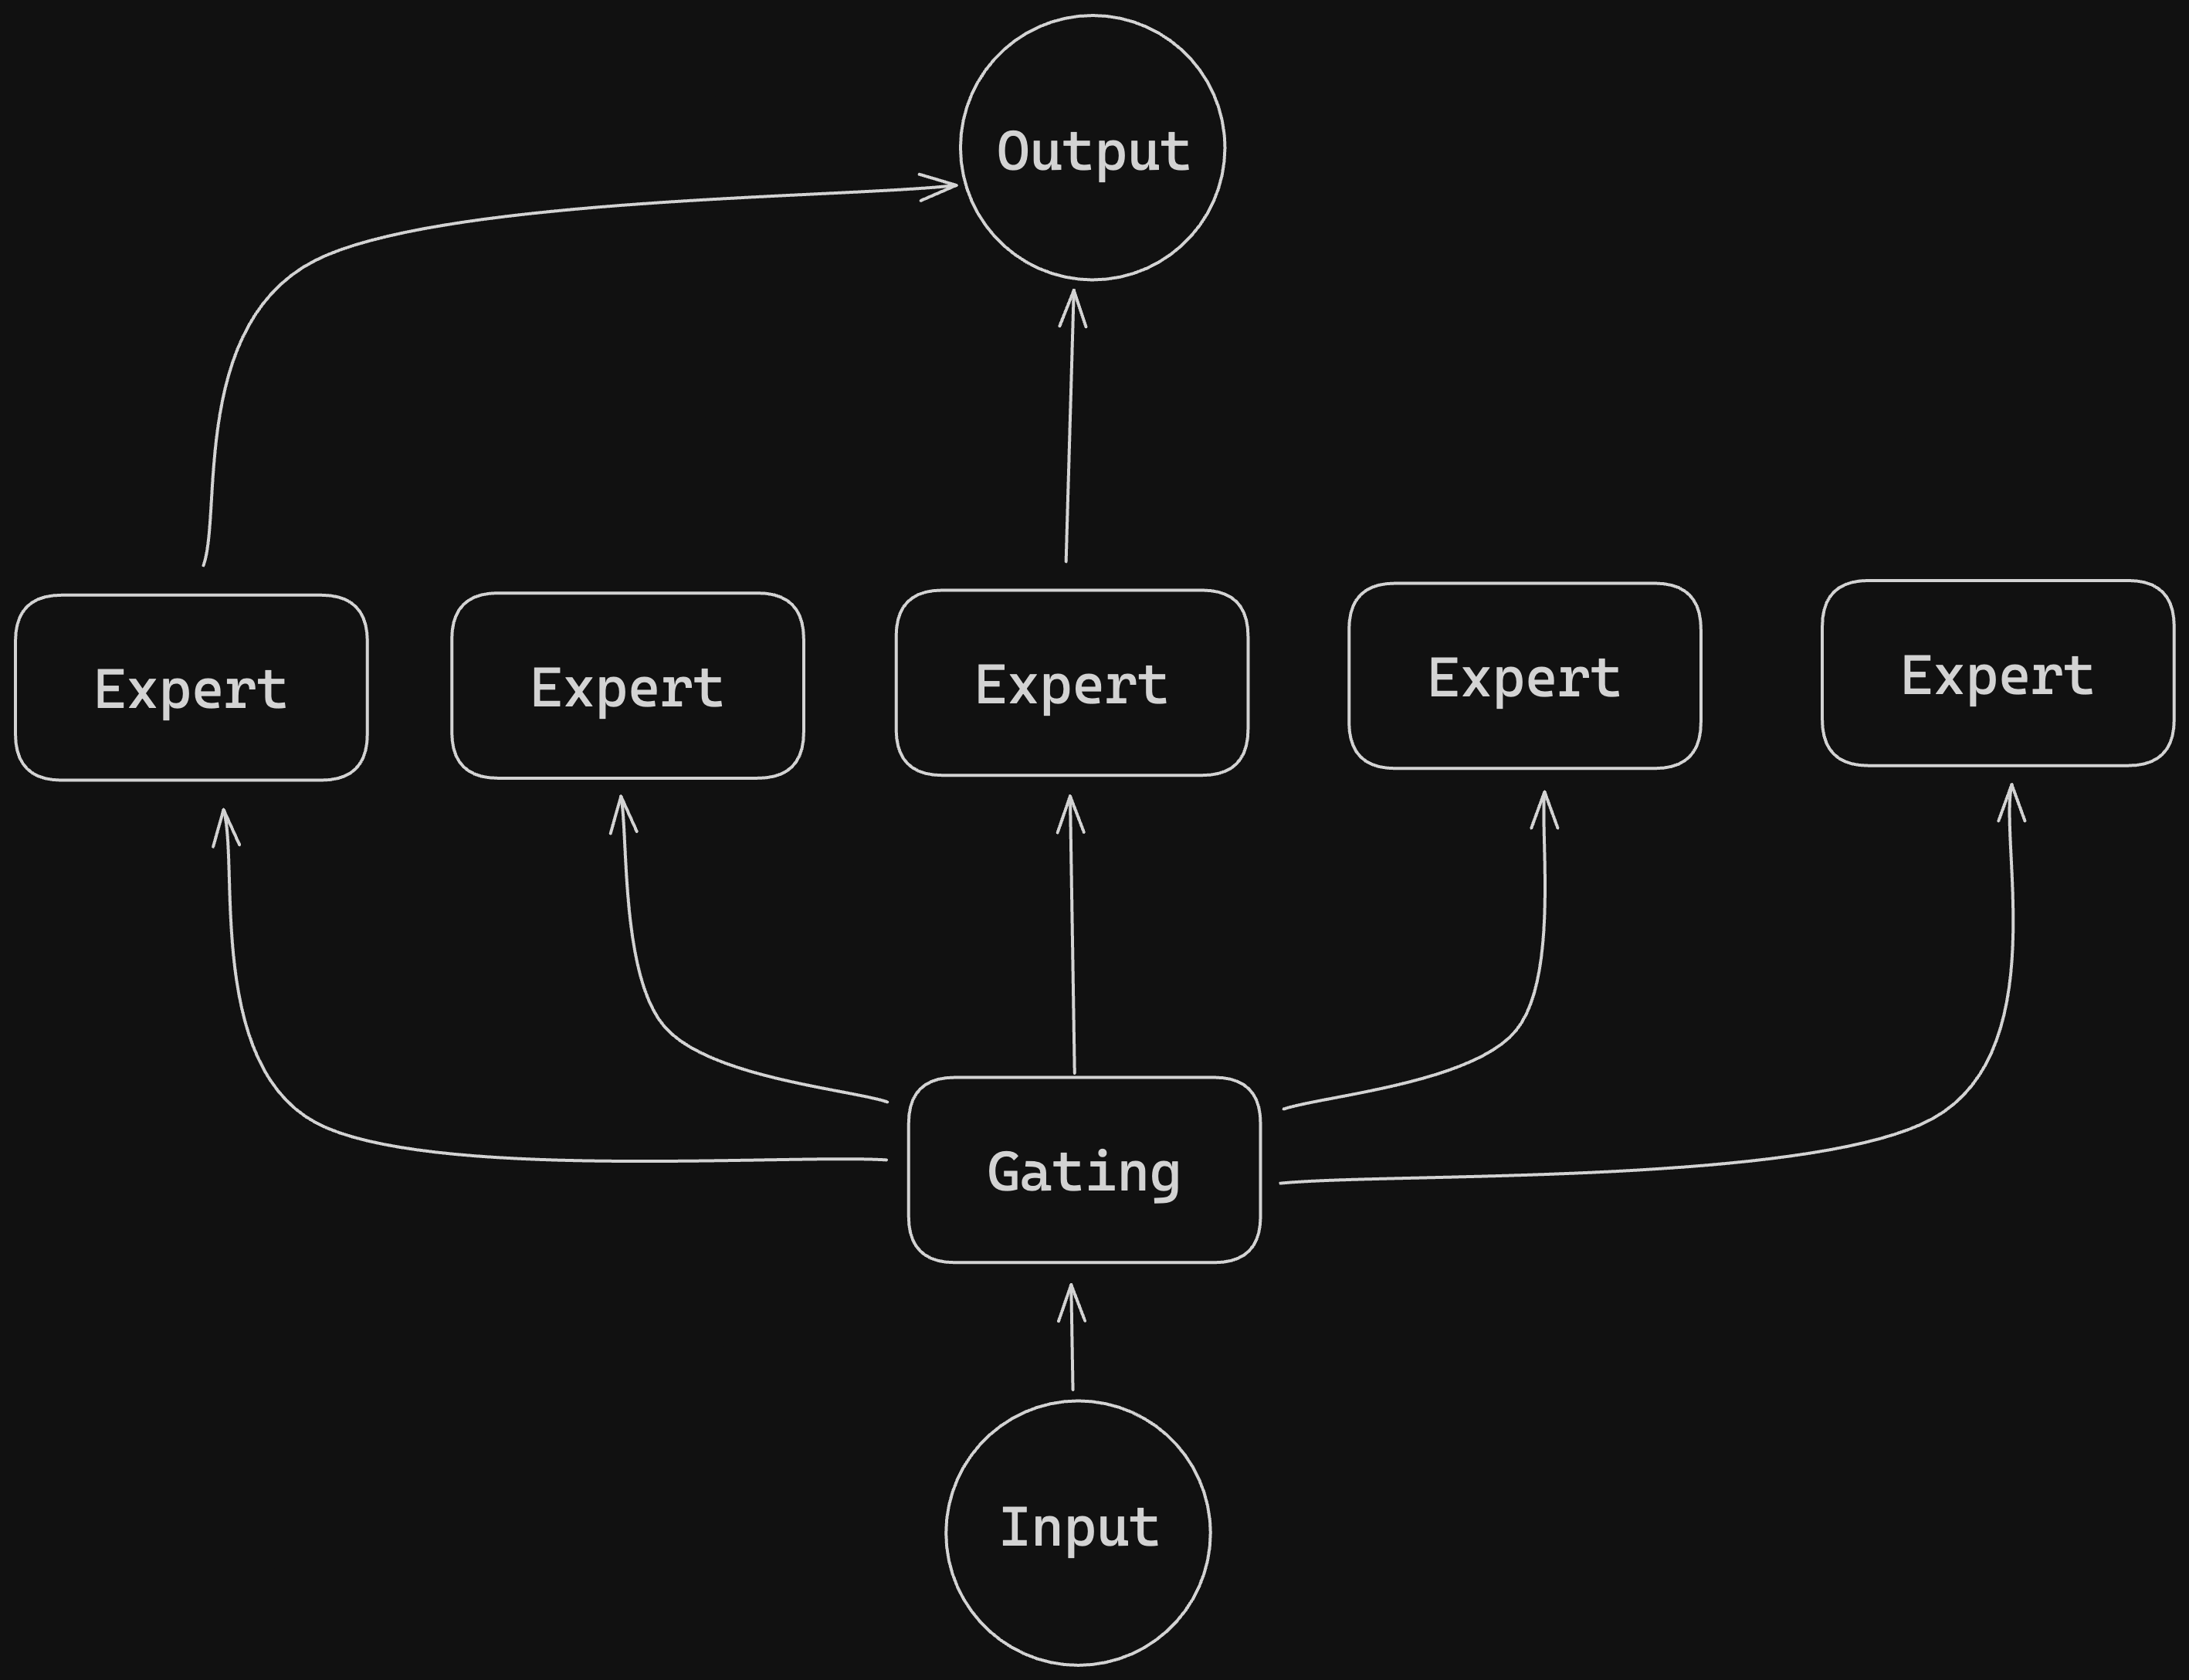

# Import Libraries

In [ ]:
from tqdm import tqdm
import numpy as np
import tensorflow as tf

# Expert Model
#### simple two sequential layers

In [3]:
# Model of two layers
class Expert(tf.keras.Model):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Expert, self).__init__()
        self.layer1 = tf.keras.layers.Dense(hidden_dim,input_shape=(input_dim,), activation=tf.nn.relu)
        self.layer2 = tf.keras.layers.Dense(output_dim, activation=tf.nn.softmax)

    def call(self, inputs):
        x = self.layer1(inputs)
        x = self.layer2(x)
        return x

# Gating Model

In [4]:
# Model 4 layers
class Gating(tf.keras.Model):
    def __init__(self, input_dim,
                 num_experts, dropout_rate=0.1):
        super(Gating, self).__init__()

        self.dropout = tf.keras.layers.Dropout(dropout_rate)

        # Layers
        self.layer1 = tf.keras.layers.Dense(input_dim,input_shape=(128,),activation=tf.nn.relu)
        self.layer2 = tf.keras.layers.Dense(256,activation=tf.nn.leaky_relu)
        self.layer3 = tf.keras.layers.Dense(128,activation=tf.nn.leaky_relu)
        self.layer4 = tf.keras.layers.Dense(num_experts,activation=tf.nn.softmax)

    def call(self, inputs):
        x = self.layer1(inputs)
        x = self.dropout(x)

        x = self.layer2(x)
        x = self.dropout(x)

        x = self.layer3(x)
        x = self.dropout(x)

        return self.layer4(x)

# MoE

In [5]:
class MoE(tf.keras.Model):
    def __init__(self, trained_experts,shape):
        super(MoE, self).__init__()
        self.experts = trained_experts

        # Freezing the experts to ensure that they are not
        # learning when MoE is training.
        # Ideally, one can free them before sending the
        # experts to the MoE; in that case the following three
        # lines can be commented out.
        for expert in self.experts:
            for layer in expert.layers:
                layer.trainable = False

        num_experts = len(trained_experts)
        # Assuming all experts have the same input dimension
        input_dim = shape
        self.gating = Gating(input_dim, num_experts)

    def call(self, inputs):
        # Get the weights from the gating network
        weights = self.gating(inputs)
        # Calculate the expert outputs
        outputs = tf.stack(
            [expert(inputs) for expert in self.experts], axis=-1)

        # Adjust the weights tensor shape to match the expert outputs
        weights = tf.expand_dims(weights, axis=1)
        weights = tf.tile(weights, multiples=[1, tf.shape(outputs)[1], 1])

        # Multiply the expert outputs with the weights and
        # sum along the third dimension
        return tf.reduce_sum(outputs * weights, axis=-1)

# Generate random dataset

In [6]:
# Generate the dataset
num_samples = 5000
input_dim = 4
hidden_dim = 32

# Generate equal numbers of labels 0, 1, and 2
y_data = np.concatenate([
    np.zeros(num_samples // 3),
    np.ones(num_samples // 3),
    np.full((num_samples - 2 * (num_samples // 3),), 2)  # Filling the remaining to ensure exact num_samples
], dtype=np.float64)

# Biasing the data based on the labels
x_data = np.random.randn(num_samples, input_dim)

for i in range(num_samples):
    if y_data[i] == 0:
        x_data[i, 0] += 1  # Making x[0] more positive
    elif y_data[i] == 1:
        x_data[i, 1] -= 1  # Making x[1] more negative
    elif y_data[i] == 2:
        x_data[i, 0] -= 1  # Making x[0] more negative

# Shuffle the data to randomize the order
indices = np.random.permutation(num_samples)
x_data = x_data[indices]
y_data = y_data[indices]

# Shuffle the data to ensure x_data and y_data remain aligned
shuffled_indices = np.random.permutation(num_samples)
x_data = x_data[shuffled_indices]
y_data = y_data[shuffled_indices]

# Splitting data for training individual experts
# Use the first half samples for training individual experts
x_train_experts = x_data[:num_samples//2]
y_train_experts = y_data[:num_samples//2]

mask_expert1 = np.logical_or(y_train_experts == 0, y_train_experts == 1)
mask_expert2 = np.logical_or(y_train_experts == 1, y_train_experts == 2)
mask_expert3 = np.logical_or(y_train_experts == 0, y_train_experts == 2)

# Select an almost equal number of samples for each expert
num_samples_per_expert = min(mask_expert1.sum(), mask_expert2.sum(), mask_expert3.sum())

x_expert1 = x_train_experts[mask_expert1][:num_samples_per_expert]
y_expert1 = y_train_experts[mask_expert1][:num_samples_per_expert]

x_expert2 = x_train_experts[mask_expert2][:num_samples_per_expert]
y_expert2 = y_train_experts[mask_expert2][:num_samples_per_expert]

x_expert3 = x_train_experts[mask_expert3][:num_samples_per_expert]
y_expert3 = y_train_experts[mask_expert3][:num_samples_per_expert]

# Splitting the next half samples for training MoE model and for testing
x_remaining = x_data[num_samples//2+1:]
y_remaining = y_data[num_samples//2+1:]

split = int(0.8 * len(x_remaining))
x_train_moe = x_remaining[:split]
y_train_moe = y_remaining[:split]

x_test = x_remaining[split:]
y_test = y_remaining[split:]

print(x_train_moe.shape,"\n", x_test.shape,"\n", x_expert1.shape,"\n", x_expert2.shape,"\n", x_expert3.shape)

(1999, 4) 
 (500, 4) 
 (1656, 4) 
 (1656, 4) 
 (1656, 4)


#### Encode the output

In [8]:
num_classes = 3

y_expert1 = tf.one_hot(y_expert1, depth=num_classes)
y_expert2 = tf.one_hot(y_expert2, depth=num_classes)
y_expert3 = tf.one_hot(y_expert3, depth=num_classes)
y_train_moe = tf.one_hot(y_train_moe, depth=num_classes)

# Training

#### build function to handle the training of the given model

In [9]:
def training_steps(model,optimizer,epochs,x,y):
  print("Training ...")
  print('\n')
  # Expert 3 trainning
  for epoch in tqdm(range(epochs)):
      with tf.GradientTape() as tape:
          pred = model(x, training=True)
          loss = criterion(pred, y)
      gradients = tape.gradient(loss, model.trainable_variables)
      optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  print('\n')
  print('-'*50)

## Experts

In [10]:
# Define hidden dimension
output_dim = 3
input_dim = 4
hidden_dim = 32

epochs = 500
learning_rate = 0.001


# Instantiate the experts
expert1 = Expert(input_dim, hidden_dim, output_dim)
expert2 = Expert(input_dim, hidden_dim, output_dim)
expert3 = Expert(input_dim, hidden_dim, output_dim)

# Set up loss
criterion = tf.keras.losses.CategoricalCrossentropy()

# Optimizers for experts
optimizer_1 = tf.keras.optimizers.Adam(learning_rate=learning_rate)
optimizer_2 = tf.keras.optimizers.Adam(learning_rate=learning_rate)
optimizer_3 = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Training for experts
training_steps(expert1,optimizer_1,epochs,x_expert1,y_expert1)
training_steps(expert2,optimizer_2,epochs,x_expert2,y_expert2)
training_steps(expert3,optimizer_3,epochs,x_expert3,y_expert3)

Training ...




100%|██████████| 500/500 [00:10<00:00, 48.53it/s]




--------------------------------------------------
Training ...




100%|██████████| 500/500 [00:08<00:00, 55.74it/s]




--------------------------------------------------
Training ...




100%|██████████| 500/500 [00:08<00:00, 55.58it/s]



--------------------------------------------------


## MoE

In [11]:
# get correct shape for all input
input_shape = (x_expert1.shape[0] and x_expert2.shape[0] and x_expert3.shape[0])

# Create the MoE model with the trained experts
moe_model = MoE([expert1, expert2, expert3],input_shape)

# Define optimizer for MoE model
optimizer_moe = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Training of MoE
training_steps(moe_model,optimizer_moe,epochs,x_train_moe,y_train_moe)

Training ...




100%|██████████| 500/500 [02:00<00:00,  4.15it/s]



--------------------------------------------------


# Evaluation

In [30]:
# Evaluate all models
def evaluate(model, x, y):
  with tf.GradientTape() as tape:
      outputs = model(x, training=False)           # Get output without training
      predicted = tf.math.argmax(outputs, axis=1)  # Get the index of the maximum value along axis 1
      correct = tf.reduce_sum(tf.cast(tf.equal(predicted, y), dtype=tf.float32))  # Count correct predictions
      accuracy = correct / tf.cast(tf.shape(y)[0], dtype=tf.float32)  # Compute accuracy
  return accuracy.numpy()

#### Modle evaluation

In [27]:
accuracy_expert1 = evaluate(expert1, x_test, y_test)
accuracy_expert2 = evaluate(expert2, x_test, y_test)
accuracy_expert3 = evaluate(expert3, x_test, y_test)
accuracy_moe = evaluate(moe_model, x_test, y_test)

print("Expert 1 Accuracy:", accuracy_expert1)
print("Expert 2 Accuracy:", accuracy_expert2)
print("Expert 3 Accuracy:", accuracy_expert3)
print("Mixture of Experts Accuracy:", accuracy_moe)

Expert 1 Accuracy: 0.528
Expert 2 Accuracy: 0.514
Expert 3 Accuracy: 0.556
Mixture of Experts Accuracy: 0.676
